<img src="https://github.com/NOAA-OWP/gval/raw/main/docs/images/gval_light_mode.png" style="float:left">

# Continuous Comparisons

In [1]:
import numpy as np
import xarray as xr
import rioxarray as rxr
import gval

## Load Datasets

In this example, the comparisons output of Variable Infiltration Capacity Model total annual CONUS precipitation in 2011 with that of the model output of PRISM, also total annual CONUS precipitation in 2011. 

- Livneh B., E.A. Rosenberg, C. Lin, B. Nijssen, V. Mishra, K.M. Andreadis, E.P. Maurer, and D.P. Lettenmaier, 2013: A Long-Term Hydrologically Based Dataset of Land Surface Fluxes and States for the Conterminous United States: Update and Extensions, Journal of Climate, 26, 9384⦣8364;⬓9392. https://psl.noaa.gov/data/gridded/data.livneh.html
- PRISM Climate Group, Oregon State University, https://prism.oregonstate.edu, data created 4 Feb 2014, accessed 16 Dec 2020. https://prism.oregonstate.edu/recent/

In [2]:
candidate = rxr.open_rasterio(
    './livneh_2011_precip.tif', mask_and_scale=True
) # VIC
benchmark = rxr.open_rasterio(
    './prism_2011_precip.tif', mask_and_scale=True
) # PRISM

## Run GVAL Continuous Compare

In [3]:
agreement, metric_table = candidate.gval.continuous_compare(benchmark)

## Output

#### Agreement Map

The agreement map in this case will be simply the difference between the two modeling outputs.

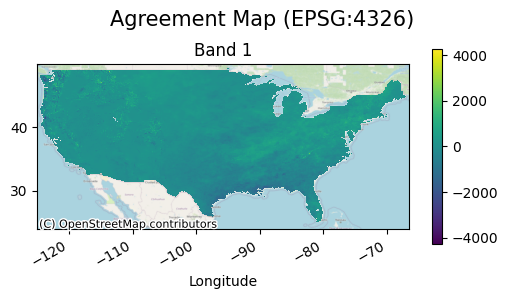

In [4]:
agreement.gval.cont_plot(title="Agreement Map", figsize=(6, 3))

In this case it is a bit difficult to see the variability of the precipitation difference, but if extreme values are masked out the map will look like the following:

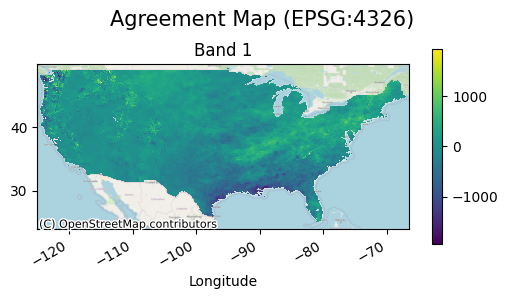

In [5]:
agreement.data = xr.where(
    (agreement < np.nanquantile(agreement.values, 0.0001)) | 
    (agreement > np.nanquantile(agreement.values, 0.9999)), 
    np.nan, 
    agreement
)
agreement.gval.cont_plot(title="Agreement Map", figsize=(6, 3))

#### Metric Table

A metric table contains information about the unit of analysis, (a single band in this case), and selected continuous metrics. Since we did not provide the metrics argument GVAL computed all of the available continuous statistics. 

In [6]:
metric_table.transpose()

,0
band,1
coefficient_of_determination,0.685261
mean_absolute_error,216.089706
mean_absolute_percentage_error,0.319234
mean_normalized_mean_absolute_error,0.267845
mean_normalized_root_mean_squared_error,0.372578
mean_percentage_error,0.010022
mean_signed_error,8.085411
mean_squared_error,90351.664062
range_normalized_mean_absolute_error,0.033065


## Alternative Uses of GVAL Continuous Operations

Aside form running the entire process, it is possible to run each of the following steps individually: homogenizing maps, computing an agreement map. This allows for flexibility in workflows so that a user may use as much or as little functionality as needed.

### Homogenize Maps

Just like in continuous comparisons, homogenizing can be done as follows:

In [7]:
candidate, benchmark = candidate.gval.homogenize(
    benchmark_map=benchmark,
    target_map = "candidate"
)

### Agreement Map

The "difference" comparison function is the default used for the `comparison_function` argument in `gval.continuous_compare` and is the only continuous comparison function available by default.  It would be advised not to use a categorical comparison function such as 'cantor', 'szudzik', or a pairing dicitonary because it could result in a very large number of classes.

Using difference in comparison:

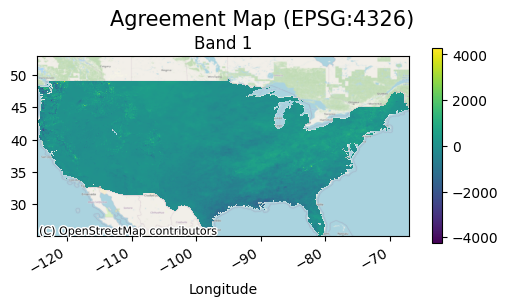

In [8]:
agreement_map = candidate.gval.compute_agreement_map(
    benchmark_map=benchmark, 
    comparison_function="difference",
    continuous=True
)

agreement_map.gval.cont_plot(title="Agreement Map", figsize=(6, 3))

The following uses an abritrary custom registered function for use in a continuous agreement map:

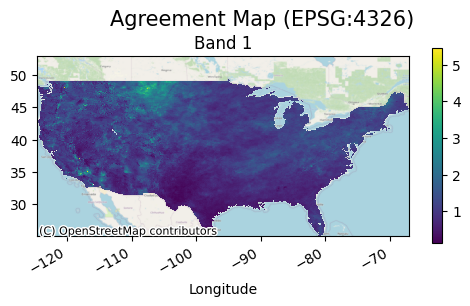

In [9]:
from gval import Comparison
from numbers import Number

@Comparison.register_function(name='divide', vectorize_func=True)
def multiply(c: Number, b: Number) -> Number:
    return c / b

agreement_map = candidate.gval.compute_agreement_map(
    benchmark_map=benchmark, 
    comparison_function="divide",
    continuous=True
)

agreement_map.gval.cont_plot(title="Agreement Map", figsize=(6, 3))

### Metric Table

Like in cateogrical compare, all metrics are computed by default if no argument is provided, `metrics` can also take a list of the desired metrics and will only return metrics in this list.

In [10]:
_, metric_table = candidate.gval.continuous_compare(
    benchmark,
    metrics=['mean_absolute_error', 'mean_squared_error']
)

metric_table

,band,mean_absolute_error,mean_squared_error
0,1,215.106232,89814.117188


Just like registering comparison functions, you are able to register a metric function on both a method and a class of functions.  Below is registering a metric function:

In [11]:
from typing import Union
import numpy as np
import xarray as xr
from gval import ContStats

@ContStats.register_function(name="min_error")
def min_error(error: Union[xr.Dataset, xr.DataArray]) -> float:
    return error.min().values

The following is registering a class of metric functions. In this case, the names associated with each function will respond to each method's name.

In [12]:
@ContStats.register_function_class()
class MetricFunctions:
    
    @staticmethod
    def median_error(error: Union[xr.Dataset, xr.DataArray]) -> float:
        return error.median().values
    
    @staticmethod
    def max_error(error: Union[xr.Dataset, xr.DataArray]) -> float:
        return error.max().values

In [13]:
_, metric_table = candidate.gval.continuous_compare(
    benchmark,
    metrics=['min_error', 'median_error', 'max_error']
)

metric_table

,band,min_error,median_error,max_error
0,1,-3035.655273,25.858208,4263.23291


## Save Output

Finally, a user can take the results and save them to a directory of their choice.  The following is an example of saving the agreement map and then the metric table:

In [14]:
# output agreement map
agreement_file = 'continuous_agreement_map.tif'
metric_file = 'continuous_metric_file.csv'

agreement_map.rio.to_raster(agreement_file)
metric_table.to_csv(metric_file)